## Welcome to Starscream Notebooks

Imported modules:

- `from datetime import datetime`
- `from shopify import suds`
- `import pandas as pd`
- `import numpy as np`
- `import matplotlib`
- `import matplotlib.pyplot as plt`
- `from starscream.datasource import read`
- `from starscream.datasource import RDD, DATAFRAME, CQUERY`

If you want to read arbitrary data from hdfs use : `read(uri,...)` run `help(read)` for info.

In [24]:
from sklearn.cluster import KMeans
import sys
import json
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
TWEETER_FEEDS = [
	'nytimes', 'thesun', 'thetimes', 'ap', 'cnn']
#	'cnn', 'bbcnews', 'cnet', 'msnuk', 'telegraph']

In [25]:
extracting_fields = ['favorite_count', 'coordinates', 'favorited', 'possibly_sensitive', 'retweet_count',
                    'retweeted', 'retweeted_status', 'entities']
tweets = []
feed_names = []
fields_dict = defaultdict(list)
for feed in TWEETER_FEEDS:
    idx = 0
    tweet_data = open('/Users/lukekumar/Documents/Twitter-App/downloaded_tweets/'+feed+'-tweet.json', 'r')
    for line in tweet_data:
        data_dict = json.loads(line)
        # print '\n'.join(np.unique(data_dict.keys()))
        fields_dict['favorite_count'].append(int(data_dict['favorite_count']) if data_dict.get('favorite_count') is not None else 0) 
        fields_dict['favorited'].append(bool(data_dict['favorited']) if data_dict.get('favorited') is not None else False)
        fields_dict['possibly_sensitive'].append(bool(data_dict['favorited']) if data_dict.get('possibly_sensitive') is not None else False)
        fields_dict['retweet_count'].append(int(data_dict['retweet_count']))
        fields_dict['retweet_count_ln'].append(math.log(int(data_dict['retweet_count'])+1))
        fields_dict['retweeted'].append(bool(data_dict['retweeted']))
        fields_dict['retweeted_status'].append(1 if data_dict.get('retweeted_status') is not None else 0)
        entities_encode = [0, 0, 0]
        if len(data_dict['entities']['hashtags']) > 0:
            entities_encode[0] = 1
        if len(data_dict['entities']['urls']) > 0:
            entities_encode[1] = 1
        if len(data_dict['entities']['user_mentions']) > 0:
            entities_encode[2] = 1
        fields_dict['entities'].append(entities_encode)
        tweets.append(data_dict['text']) 
        feed_names.append(data_dict['user']['screen_name'])
    tweet_data.close()

In [26]:
fields_dict.keys()

['favorited',
 'retweeted_status',
 'retweeted',
 'retweet_count_ln',
 'entities',
 'favorite_count',
 'retweet_count',
 'possibly_sensitive']

In [ ]:
hist, bins = np.histogram(fields_dict['retweet_count'], bins=25)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("Feature: retweet_count")
plt.show()

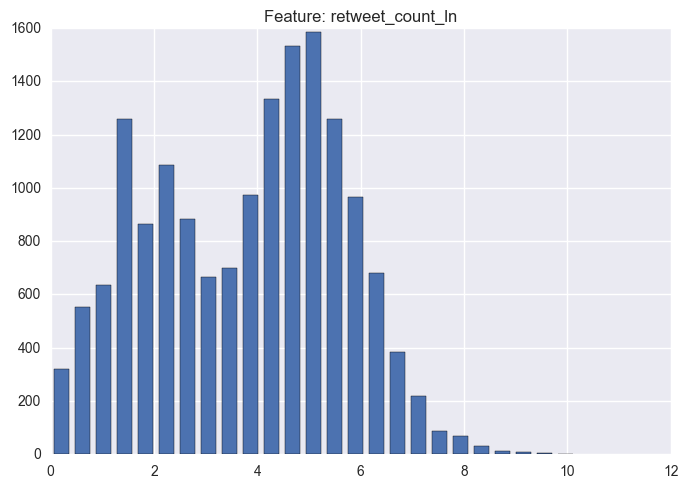

In [27]:
hist, bins = np.histogram(fields_dict['retweet_count_ln'], bins=25)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("Feature: retweet_count_ln")
plt.show()

In [28]:
fields_dict.keys()

['favorited',
 'retweeted_status',
 'retweeted',
 'retweet_count_ln',
 'entities',
 'favorite_count',
 'retweet_count',
 'possibly_sensitive']

In [49]:
X = pd.DataFrame()
X['favorited'] = fields_dict['favorited']
X['retweeted_status'] = fields_dict['retweeted_status']
X['retweeted'] = fields_dict['retweeted']
X['entities_h'] = map(lambda x:x[0], fields_dict['entities'])
X['entities_u'] = map(lambda x:x[0], fields_dict['entities'])
X['entities_m'] = map(lambda x:x[0], fields_dict['entities'])
X['favorite_count'] = fields_dict['favorite_count']
X['possibly_sensitive'] = fields_dict['possibly_sensitive']
y = pd.DataFrame()
y['target'] = fields_dict['retweet_count_ln']

In [50]:
X.shape

(16102, 8)

In [51]:
X.dtypes

favorited              bool
retweeted_status      int64
retweeted              bool
entities_h            int64
entities_u            int64
entities_m            int64
favorite_count        int64
possibly_sensitive     bool
dtype: object

In [52]:
y.dtypes

target    float64
dtype: object

In [110]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy import interp
import matplotlib.pyplot as plt


#Set Seed to avoid changes based on Randomness 
np.random.seed(123456)

from time import time

n_samples, n_features = X.shape
print "num features: ", n_features
print "avg Y: ", np.mean(y)

RANDOM_STATE = None

kf = KFold(n_splits = 5, random_state = RANDOM_STATE, shuffle = True)

# Range of Features
max_feature_range = range(1, int(np.floor(np.sqrt(n_features))), 2) + \
                    range(int(np.floor(np.sqrt(n_features))), n_features, 2)
max_feature_range = [6] #['auto'] #[int(np.floor(np.sqrt(n_features)))]
print "max_feature range: ", max_feature_range

# Range Trees 
min_tree = 100
max_tree = 100
delta    = 1

print 'num trees: ', range(min_tree, max_tree+1, delta)

depth_range = [5, 10, 15, 20, 25, 50, None]
depth_range = [5]# [None]
print "depth: ", depth_range
#Parrellel Job
num_jobs = 100

num features:  8
avg Y:  target    3.793313
dtype: float64
max_feature range:  [6]
num trees:  [100]
depth:  [5]


In [101]:
def run_grid_search(X, y):
    
    results = pd.DataFrame(columns=['max_features', 'max_depth', 'n_estimators', 'time',\
                                    'mean-mse', 'std-mse', 'train_oob_error'])
    index = 0
    for max_features in max_feature_range:
        
        for max_depth in depth_range:

            for num_trees in range(min_tree, max_tree+1, delta):

                rf = RandomForestRegressor(criterion='mse', n_jobs = num_jobs, oob_score = True, \
                                            n_estimators = num_trees, max_features = max_features, \
                                            min_samples_split = 2, max_depth = max_depth) 

                #rf = LogisticRegression(class_weight='balanced', max_iter=1000)
                #skf = StratifiedKFold(y, 5, shuffle=True)

                lst_mse   = []
                lst_oob_error  = []
                lst_predictions = []
                lst_labels = []

                start = time()

                for train_index, test_index in kf.split(X):
                   
                    X_train, X_test = X.loc[train_index], X.loc[test_index]
                    y_train, y_test = y.loc[train_index], y.loc[test_index]

                    # print "train: ", X_train.shape, "\ttest: ", X_test.shape
                    
                    rf.fit(X_train, y_train)
                    prediction = rf.predict(X_test)
                    lst_predictions += prediction.tolist()
                    lst_labels += y_test.values.tolist()
                    lst_oob_error.append(1 - rf.oob_score_)
                    lst_mse.append(mean_squared_error(y_test, prediction))

                end = time()
            
                print 'max_features =', max_features, 'max_depth =', max_depth, 'n_estimators =', num_trees,\
                    'mean-mse: ',  np.mean(lst_mse)           
            
                results.loc[index] = [max_features, max_depth, num_trees, end-start, np.mean(lst_mse), \
                                      np.std(lst_mse), np.mean(lst_oob_error)]
                index = index + 1
        
    return results, lst_predictions, lst_labels

In [102]:
NewX = X.copy()
print NewX.columns
res, pred, label = run_grid_search(NewX.copy(), y.copy())
res

Index([u'favorited', u'retweeted_status', u'retweeted', u'entities_h',
       u'entities_u', u'entities_m', u'favorite_count', u'possibly_sensitive'],
      dtype='object')


/Users/lukekumar/.virtualenvs/starscream/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_features = 6 max_depth = 5 n_estimators = 100 mean-mse:  0.662537397466


,max_features,max_depth,n_estimators,time,mean-mse,std-mse,train_oob_error
0,6.0,5.0,100.0,3.124662,0.662537,0.018267,0.196669


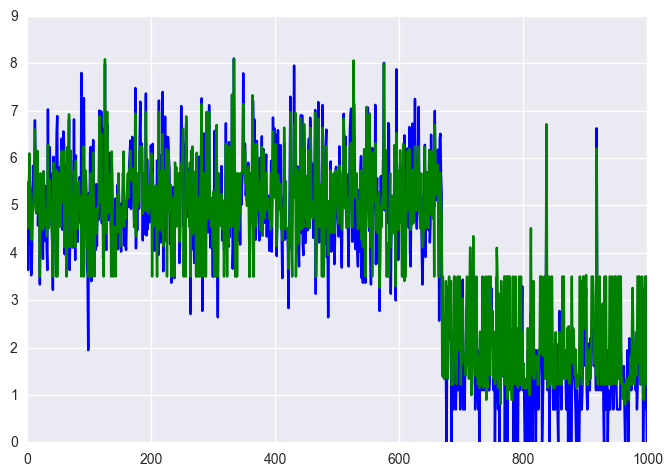

In [115]:
plt.plot(label[0:1000], color='b')
plt.plot(pred[0:1000], color='g')
plt.show()

In [83]:
NewX = X.copy()
print NewX.columns
#res = run_grid_search(NewX.copy(), y.copy())
res

Index([u'favorited', u'retweeted_status', u'retweeted', u'entities_h',
       u'entities_u', u'entities_m', u'favorite_count', u'possibly_sensitive'],
      dtype='object')


/Users/lukekumar/.virtualenvs/starscream/lib/python2.7/site-packages/ipykernel/__main__.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_features = 1 max_depth = 5 n_estimators = 100 mean-mse:  0.669419106811
max_features = 1 max_depth = 10 n_estimators = 100 mean-mse:  0.662440585865
max_features = 1 max_depth = 15 n_estimators = 100 mean-mse:  0.67192451313
max_features = 1 max_depth = 20 n_estimators = 100 mean-mse:  0.679171853986
max_features = 1 max_depth = 25 n_estimators = 100 mean-mse:  0.679786649462
max_features = 1 max_depth = 50 n_estimators = 100 mean-mse:  0.679756088494
max_features = 1 max_depth = None n_estimators = 100 mean-mse:  0.680226669262
max_features = 2 max_depth = 5 n_estimators = 100 mean-mse:  0.667052018755
max_features = 2 max_depth = 10 n_estimators = 100 mean-mse:  0.663069424632
max_features = 2 max_depth = 15 n_estimators = 100 mean-mse:  0.671283256335
max_features = 2 max_depth = 20 n_estimators = 100 mean-mse:  0.678184727771
max_features = 2 max_depth = 25 n_estimators = 100 mean-mse:  0.6792611001
max_features = 2 max_depth = 50 n_estimators = 100 mean-mse:  0.681120612292
ma

,max_features,max_depth,n_estimators,time,mean-mse,std-mse,train_oob_error
0,1.0,5.0,100.0,3.108675,0.669419,0.025367,0.198816
1,1.0,10.0,100.0,3.170891,0.662441,0.021650,0.196550
2,1.0,15.0,100.0,3.265849,0.671925,0.020150,0.199501
3,1.0,20.0,100.0,2.934065,0.679172,0.018615,0.201328
4,1.0,25.0,100.0,3.058642,0.679787,0.021532,0.201844
5,1.0,50.0,100.0,3.158677,0.679756,0.026093,0.201947
6,1.0,NaN,100.0,3.027971,0.680227,0.014082,0.201953
7,2.0,5.0,100.0,3.030173,0.667052,0.014867,0.198224
8,2.0,10.0,100.0,3.168870,0.663069,0.024182,0.196579
9,2.0,15.0,100.0,3.212041,0.671283,0.036241,0.199500
